# Processing sequences : Recurrent Neural Networks

They are used for time series predictions. Regular dense networks can also do it, and CNNs can also work for very long time series.
A recurrent neuron  receives an input *and* the output from the neuron at the previous time step. Because each neuron learns from the previous time step, it has *memory*; but these simple cells have relatively short memory (10 cells about).
RNNs take in a sequence and output a sequence.



In [24]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

**Synthetic data**

Let's create a synthetic time series

In [3]:
def generate_time_series(batch_size,n_steps):
    f1,f2,off1,off2=np.random.rand(4,batch_size,1)
    t = np.linspace(0,1,n_steps)
    y = 0.5*np.sin( (t-off1)*(f1*10+10) ) # first wave
    y += 0.5*np.sin( (t-off2)*(f2*20+20) ) # second wave
    y += 0.1* (np.random.rand(batch_size,n_steps)-0.5) # noise
    return y[...,np.newaxis].astype(np.float32) 
# here we added a dimension to the ouput time series because most ML algorithms can be multidimensional, but here we are just doing a single time series.

# we generate 10k time series of 51 points.
n_steps=50
y = generate_time_series(10000,n_steps+1)

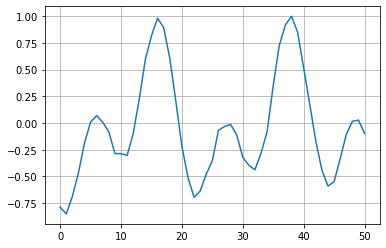

In [19]:
plt.plot(y[5000,:]);plt.grid(True)

**train-validation-test split**

In forecasting problem, we do not want to shuffle the training and test set since we want to make sure test is a prediction from the past (training).

The training data are time series of 50 points, the "label" or "model output" is the **last value** of the time series.

In [4]:
x_train,y_train = y[:7000,:n_steps],y[:7000,-1] 
x_val,y_val = y[7000:9000,:n_steps],y[7000:9000,-1] 
x_test,y_test = y[9000:,:n_steps],y[9000:,-1] 

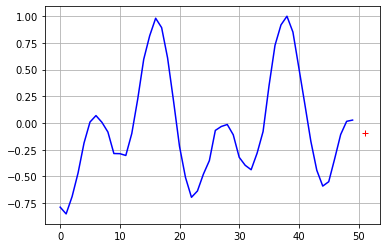

In [22]:
plt.plot(np.arange(n_steps),x_train[5000,:],'b')
plt.plot(51,y_train[5000],'r+')
plt.grid(True)

**Two baseline metrics**

We can use the past values to predict the state, called *naive forecasting*:
```python
y_pred=x_val[:,-1]
```

Or we can use a fully connected network and predict the value as a MLP regression:

```python
model.keras.models.Sequential([keras.layers.Flatten(input_shape=[50,1]),
                              keras.layers.Dense(1)])
```
They don't do too bad in this problem. The simple block is a ``simpleRNN``. The simplest recurrent neuron is a ``SimpleRNN(1,input_shape=[None,1])`` that takes any inout scalar since it can process any number of time steps. The default activation function is ``tanh``. To return a time series, and not its final output, you need to set ``return_sequences=True``. It turns out that the simplest and single recurrent neuron won't work. So we stack several simpleRNNs.

In [23]:
model=keras.models.Sequential([
    keras.layers.SimpleRNN(20,input_shape=[None,1],return_sequences=True),
    keras.layers.SimpleRNN(20,return_sequences=True),
    keras.layers.SimpleRNN(1)
    ])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_11 (SimpleRNN)    (None, None, 20)          440       
_________________________________________________________________
simple_rnn_12 (SimpleRNN)    (None, None, 20)          820       
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 1)                 22        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(optimizer='adam',loss='mse',metrics=['mse'])
history=model.fit(x_train,y_train,validation_data=(x_val,y_val), epochs=20, batch_size=128) 

Epoch 1/20
55/55 [==============================] - 3s 26ms/step - loss: 0.0216 - mse: 0.0216 - val_loss: 0.0137 - val_mse: 0.0137
Epoch 2/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 3/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 4/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 5/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 6/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 7/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 8/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0080 - m

Text(0.5, 0, 'epochs')

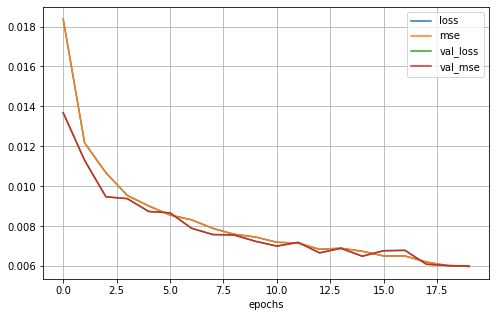

In [28]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.xlabel('epochs')

In [42]:
model=keras.models.Sequential([
    keras.layers.SimpleRNN(20,input_shape=[None,1],return_sequences=True),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
    ])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_16 (SimpleRNN)    (None, None, 20)          440       
_________________________________________________________________
simple_rnn_17 (SimpleRNN)    (None, 20)                820       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile(optimizer='adam',loss='mse',metrics=['mse'])
history=model.fit(x_train,y_train,validation_data=(x_val,y_val), epochs=20, batch_size=128) 

Epoch 1/20
55/55 [==============================] - 2s 26ms/step - loss: 0.1676 - mse: 0.1676 - val_loss: 0.0182 - val_mse: 0.0182
Epoch 2/20
55/55 [==============================] - 1s 15ms/step - loss: 0.0150 - mse: 0.0150 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 3/20
55/55 [==============================] - 1s 15ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 4/20
55/55 [==============================] - 1s 15ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 5/20
55/55 [==============================] - 1s 15ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 6/20
55/55 [==============================] - 1s 15ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 7/20
55/55 [==============================] - 1s 15ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 8/20
55/55 [==============================] - 1s 15ms/step - loss: 0.0045 - m

Text(0.5, 0, 'epochs')

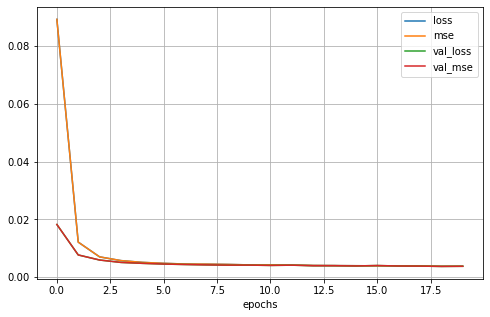

In [44]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.xlabel('epochs')

## Forecast of several steps ahead: how far can you predict the future?
We will try and predict 10 steps ahead. The early part of the forecast will be a lot better than the later part of the forecast as uncertainties increase.

In [60]:
# we generate 10k time series of 51 points.
n_steps=50
x = generate_time_series(10000,n_steps+10)
y=np.empty((10000,n_steps,10))
for step_ahead in range(1,10+1):
    y[:,:,step_ahead-1]=x[:,step_ahead:step_ahead+n_steps,0]

    
x_train=x[:7000,:n_steps]
x_val=x[7000:9000,:n_steps]
x_test=x[9000:,:n_steps]

y_train=y[:7000]
y_val=y[7000:9000]
y_test=y[9000:]


In [61]:
model=keras.models.Sequential([
    keras.layers.SimpleRNN(20,input_shape=[None,1],return_sequences=True),
    keras.layers.SimpleRNN(20,return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
    ])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_26 (SimpleRNN)    (None, None, 20)          440       
_________________________________________________________________
simple_rnn_27 (SimpleRNN)    (None, None, 20)          820       
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 10)          210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.compile(optimizer='adam',loss='mse',metrics=['mse'])c
history=model.fit(x_train,y_train,validation_data=(x_val,y_val), epochs=20, batch_size=128) 

Epoch 1/20
55/55 [==============================] - 2s 18ms/step - loss: 0.3873 - mse: 0.3873 - val_loss: 0.1880 - val_mse: 0.1880
Epoch 2/20
55/55 [==============================] - 1s 15ms/step - loss: 0.1685 - mse: 0.1685 - val_loss: 0.1319 - val_mse: 0.1319
Epoch 3/20
55/55 [==============================] - 1s 15ms/step - loss: 0.1255 - mse: 0.1255 - val_loss: 0.1148 - val_mse: 0.1148
Epoch 4/20
55/55 [==============================] - 1s 15ms/step - loss: 0.1114 - mse: 0.1114 - val_loss: 0.1061 - val_mse: 0.1061
Epoch 5/20
55/55 [==============================] - 1s 15ms/step - loss: 0.1043 - mse: 0.1043 - val_loss: 0.1001 - val_mse: 0.1001
Epoch 6/20
55/55 [==============================] - 1s 15ms/step - loss: 0.0983 - mse: 0.0983 - val_loss: 0.0955 - val_mse: 0.0955
Epoch 7/20
55/55 [==============================] - 1s 16ms/step - loss: 0.0940 - mse: 0.0940 - val_loss: 0.0913 - val_mse: 0.0913
Epoch 8/20
55/55 [==============================] - 1s 15ms/step - loss: 0.0898 - m

In [74]:
y_pred=model.predict(x_test)
print(y_pred.shape)
print(x_test.shape)
print(y_test.shape)

(1000, 50, 10)
(1000, 50, 1)
(1000, 50, 10)


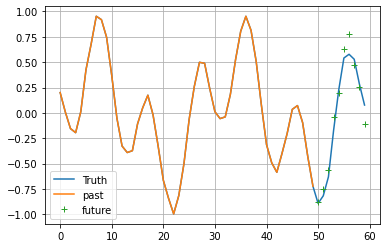

In [82]:
plt.plot(np.arange(n_steps+10),x[9000,:])
plt.plot(np.arange(n_steps),x_test[0,:])
plt.plot(np.arange(10)+n_steps,y_pred[0,-1,:],'+')
plt.legend(('Truth','past','future'))
plt.grid(True)

## Problems with RNNs and solutions

unstable gradients, requires regularization and normalizations

### 2. LSTM
Long-Short Term Memory are (somewhat complicated) cells that aims to solve the memory loss issue.

<img src="lstm.png" alt="lstm" style="width: 400px;"/>



In [83]:
model=keras.models.Sequential([
    keras.layers.LSTM(20,input_shape=[None,1],return_sequences=True),
    keras.layers.LSTM(20,return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
    ])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 20)          1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 10)          210       
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________


In [85]:
model.compile(optimizer='adam',loss='mse',metrics=['mse'])
history=model.fit(x_train,y_train,validation_data=(x_val,y_val), epochs=20, batch_size=128) 

Epoch 1/20
55/55 [==============================] - 4s 43ms/step - loss: 0.2395 - mse: 0.2395 - val_loss: 0.1965 - val_mse: 0.1965
Epoch 2/20
55/55 [==============================] - 2s 34ms/step - loss: 0.1892 - mse: 0.1892 - val_loss: 0.1709 - val_mse: 0.1709
Epoch 3/20
55/55 [==============================] - 2s 34ms/step - loss: 0.1658 - mse: 0.1658 - val_loss: 0.1447 - val_mse: 0.1447
Epoch 4/20
55/55 [==============================] - 2s 34ms/step - loss: 0.1373 - mse: 0.1373 - val_loss: 0.1177 - val_mse: 0.1177
Epoch 5/20
55/55 [==============================] - 2s 34ms/step - loss: 0.1129 - mse: 0.1129 - val_loss: 0.1025 - val_mse: 0.1025
Epoch 6/20
55/55 [==============================] - 2s 34ms/step - loss: 0.0989 - mse: 0.0989 - val_loss: 0.0926 - val_mse: 0.0926
Epoch 7/20
55/55 [==============================] - 2s 34ms/step - loss: 0.0923 - mse: 0.0923 - val_loss: 0.0879 - val_mse: 0.0879
Epoch 8/20
55/55 [==============================] - 2s 34ms/step - loss: 0.0865 - m

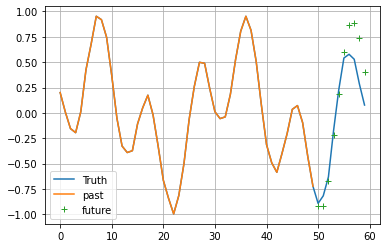

In [86]:
y_pred=model.predict(x_test)
plt.plot(np.arange(n_steps+10),x[9000,:])
plt.plot(np.arange(n_steps),x_test[0,:])
plt.plot(np.arange(10)+n_steps,y_pred[0,-1,:],'+')
plt.legend(('Truth','past','future'))
plt.grid(True)